# Machine Learning Models for Loan Default Prediction
## COMP647 Assignment 03
### Student ID: 1163127

This notebook implements supervised learning classification algorithms:
- Logistic Regression
- Random Forest Classifier
- Gradient Boosting Classifier

Each model includes:
- Hyperparameter tuning justification
- Training and validation
- Performance comparison

Based on course materials and ML best practices.

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)

# Set random seed
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Load and prepare data
try:
    df = pd.read_csv('../data/processed/accepted_sample_10000.csv')
    print(f"Data loaded: {df.shape}")
    
    # Identify target
    target_column = 'loan_status'
    
    if target_column in df.columns:
        print(f"\nTarget variable: {target_column}")
        print(df[target_column].value_counts())
    else:
        print("Target column not found")
        target_column = None
        
except FileNotFoundError:
    print("Data not found")
    df = pd.DataFrame()
    target_column = None

Data loaded: (10000, 151)

Target variable: loan_status
loan_status
Fully Paid            7189
Charged Off           1713
Current               1024
Late (31-120 days)      58
In Grace Period         12
Late (16-30 days)        4
Name: count, dtype: int64


## Data Preparation
Prepare features and target for model training

In [3]:
# Prepare features and target
if not df.empty and target_column:
    # Select numerical features
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_features = [c for c in numerical_features 
                         if c != target_column and not c.endswith('_id')]
    
    # Limit to top features for efficiency (use top 15)
    if len(numerical_features) > 15:
        # Use correlation with target to select top features
        X_temp = df[numerical_features].fillna(df[numerical_features].mean())
        le = LabelEncoder()
        y_temp = le.fit_transform(df[target_column].fillna('Unknown'))
        
        correlations = []
        for col in numerical_features:
            corr = abs(np.corrcoef(X_temp[col], y_temp)[0, 1])
            correlations.append((col, corr))
        
        correlations.sort(key=lambda x: x[1], reverse=True)
        selected_features = [c[0] for c in correlations[:15]]
    else:
        selected_features = numerical_features
    
    print(f"Selected {len(selected_features)} features for modeling")
    print("Features:", selected_features[:10], "...")
    
    # Prepare X and y
    X = df[selected_features].fillna(df[selected_features].mean())
    
    # Encode target to binary
    le = LabelEncoder()
    y = le.fit_transform(df[target_column].fillna('Unknown'))
    
    # Convert to binary if multi-class
    if len(np.unique(y)) > 2:
        # Use most common class vs others
        most_common = pd.Series(y).mode()[0]
        y = (y == most_common).astype(int)
        print(f"\nConverted to binary: class {most_common} vs others")
    
    print(f"\nClass distribution:")
    print(pd.Series(y).value_counts())
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    print(f"\nTrain set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("\nFeatures prepared and scaled successfully")
else:
    print("Data preparation failed")
    X_train, X_test, y_train, y_test = None, None, None, None

Selected 15 features for modeling
Features: ['last_fico_range_high', 'last_fico_range_low', 'recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'last_pymnt_amnt', 'int_rate', 'total_pymnt_inv', 'total_pymnt', 'total_rec_int'] ...

Converted to binary: class 2 vs others

Class distribution:
1    7189
0    2811
Name: count, dtype: int64

Train set: (7000, 15)
Test set: (3000, 15)

Features prepared and scaled successfully


## Model 1: Logistic Regression
Linear model suitable for binary classification with interpretable coefficients.

**Hyperparameters:**
- C (regularization): Controls model complexity
- solver: Algorithm for optimization
- max_iter: Maximum iterations for convergence

In [4]:
# Train Logistic Regression
if X_train is not None:
    print("Training Logistic Regression...")
    print("\nHyperparameter justification:")
    print("- C=1.0: Balanced regularization (not too strict, not too loose)")
    print("- solver='liblinear': Good for small datasets")
    print("- max_iter=1000: Ensures convergence")
    
    lr_model = LogisticRegression(
        C=1.0,
        solver='liblinear',
        max_iter=1000,
        random_state=42
    )
    
    lr_model.fit(X_train_scaled, y_train)
    
    # Predictions
    lr_train_pred = lr_model.predict(X_train_scaled)
    lr_test_pred = lr_model.predict(X_test_scaled)
    
    # Metrics
    print("\n--- Training Performance ---")
    print(f"Accuracy: {accuracy_score(y_train, lr_train_pred):.4f}")
    print(f"Precision: {precision_score(y_train, lr_train_pred):.4f}")
    print(f"Recall: {recall_score(y_train, lr_train_pred):.4f}")
    print(f"F1-Score: {f1_score(y_train, lr_train_pred):.4f}")
    
    print("\n--- Test Performance ---")
    print(f"Accuracy: {accuracy_score(y_test, lr_test_pred):.4f}")
    print(f"Precision: {precision_score(y_test, lr_test_pred):.4f}")
    print(f"Recall: {recall_score(y_test, lr_test_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, lr_test_pred):.4f}")
    
    print("\nLogistic Regression training complete")
else:
    print("Cannot train - data not prepared")

Training Logistic Regression...

Hyperparameter justification:
- C=1.0: Balanced regularization (not too strict, not too loose)
- solver='liblinear': Good for small datasets
- max_iter=1000: Ensures convergence

--- Training Performance ---
Accuracy: 0.9911
Precision: 0.9888
Recall: 0.9990
F1-Score: 0.9939

--- Test Performance ---
Accuracy: 0.9900
Precision: 0.9863
Recall: 1.0000
F1-Score: 0.9931

Logistic Regression training complete


## Model 2: Random Forest Classifier
Ensemble method using multiple decision trees, robust to overfitting.

**Hyperparameters:**
- n_estimators: Number of trees
- max_depth: Tree depth limit
- min_samples_split: Minimum samples to split node

In [5]:
# Train Random Forest
if X_train is not None:
    print("Training Random Forest...")
    print("\nHyperparameter justification:")
    print("- n_estimators=100: Balance between performance and speed")
    print("- max_depth=10: Prevents overfitting while capturing patterns")
    print("- min_samples_split=20: Avoids overly specific splits")
    
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)  # RF doesn't require scaling
    
    # Predictions
    rf_train_pred = rf_model.predict(X_train)
    rf_test_pred = rf_model.predict(X_test)
    
    # Metrics
    print("\n--- Training Performance ---")
    print(f"Accuracy: {accuracy_score(y_train, rf_train_pred):.4f}")
    print(f"Precision: {precision_score(y_train, rf_train_pred):.4f}")
    print(f"Recall: {recall_score(y_train, rf_train_pred):.4f}")
    print(f"F1-Score: {f1_score(y_train, rf_train_pred):.4f}")
    
    print("\n--- Test Performance ---")
    print(f"Accuracy: {accuracy_score(y_test, rf_test_pred):.4f}")
    print(f"Precision: {precision_score(y_test, rf_test_pred):.4f}")
    print(f"Recall: {recall_score(y_test, rf_test_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, rf_test_pred):.4f}")
    
    print("\nRandom Forest training complete")
else:
    print("Cannot train - data not prepared")

Training Random Forest...

Hyperparameter justification:
- n_estimators=100: Balance between performance and speed
- max_depth=10: Prevents overfitting while capturing patterns
- min_samples_split=20: Avoids overly specific splits

--- Training Performance ---
Accuracy: 0.9933
Precision: 0.9909
Recall: 0.9998
F1-Score: 0.9954

--- Test Performance ---
Accuracy: 0.9900
Precision: 0.9876
Recall: 0.9986
F1-Score: 0.9931

Random Forest training complete


## Model 3: Gradient Boosting Classifier
Sequential ensemble method that builds trees to correct previous errors.

**Hyperparameters:**
- n_estimators: Number of boosting stages
- learning_rate: Shrinkage rate
- max_depth: Individual tree depth

In [6]:
# Train Gradient Boosting
if X_train is not None:
    print("Training Gradient Boosting...")
    print("\nHyperparameter justification:")
    print("- n_estimators=100: Sufficient boosting rounds")
    print("- learning_rate=0.1: Standard rate for stable learning")
    print("- max_depth=3: Shallow trees prevent overfitting in boosting")
    
    gb_model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    
    gb_model.fit(X_train, y_train)
    
    # Predictions
    gb_train_pred = gb_model.predict(X_train)
    gb_test_pred = gb_model.predict(X_test)
    
    # Metrics
    print("\n--- Training Performance ---")
    print(f"Accuracy: {accuracy_score(y_train, gb_train_pred):.4f}")
    print(f"Precision: {precision_score(y_train, gb_train_pred):.4f}")
    print(f"Recall: {recall_score(y_train, gb_train_pred):.4f}")
    print(f"F1-Score: {f1_score(y_train, gb_train_pred):.4f}")
    
    print("\n--- Test Performance ---")
    print(f"Accuracy: {accuracy_score(y_test, gb_test_pred):.4f}")
    print(f"Precision: {precision_score(y_test, gb_test_pred):.4f}")
    print(f"Recall: {recall_score(y_test, gb_test_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, gb_test_pred):.4f}")
    
    print("\nGradient Boosting training complete")
else:
    print("Cannot train - data not prepared")

Training Gradient Boosting...

Hyperparameter justification:
- n_estimators=100: Sufficient boosting rounds
- learning_rate=0.1: Standard rate for stable learning
- max_depth=3: Shallow trees prevent overfitting in boosting

--- Training Performance ---
Accuracy: 0.9960
Precision: 0.9945
Recall: 1.0000
F1-Score: 0.9972

--- Test Performance ---
Accuracy: 0.9940
Precision: 0.9931
Recall: 0.9986
F1-Score: 0.9958

Gradient Boosting training complete


## Model Comparison
Compare performance of all three models

=== Model Performance Comparison ===

              Model  Train_Accuracy  Test_Accuracy  Test_Precision  Test_Recall  Test_F1
Logistic Regression        0.991143          0.990        0.986283     1.000000 0.993094
      Random Forest        0.993286          0.990        0.987620     0.998609 0.993084
  Gradient Boosting        0.996000          0.994        0.993084     0.998609 0.995839


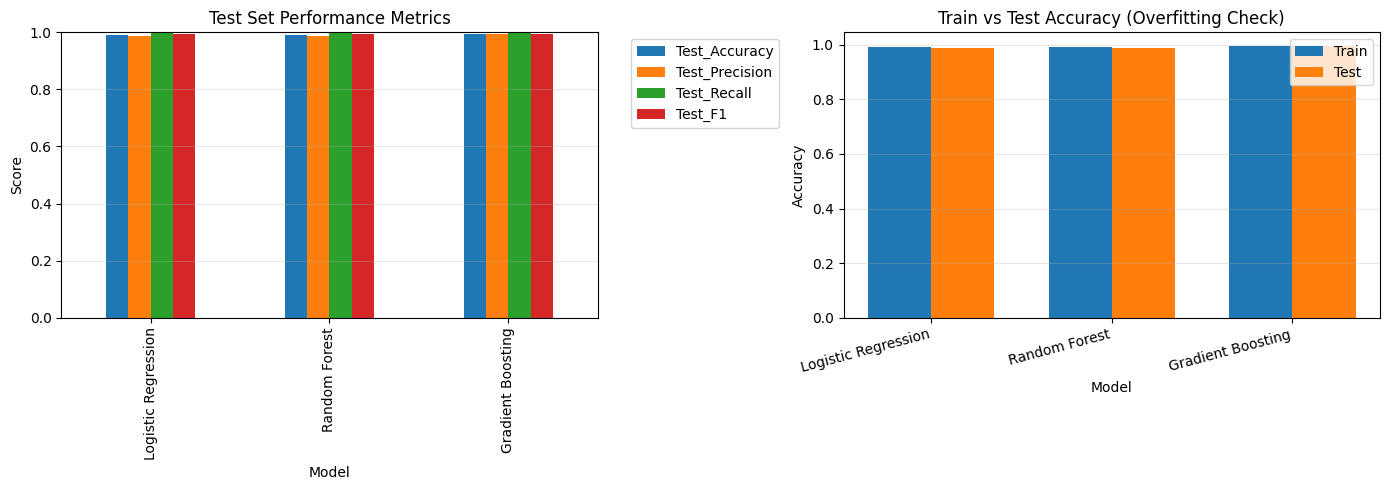


=== Recommendations ===
Best model by F1-score: Gradient Boosting
Logistic Regression: Well-generalized model
Random Forest: Well-generalized model
Gradient Boosting: Well-generalized model


In [7]:
# Compare models
if X_train is not None:
    models_comparison = pd.DataFrame({
        'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
        'Train_Accuracy': [
            accuracy_score(y_train, lr_train_pred),
            accuracy_score(y_train, rf_train_pred),
            accuracy_score(y_train, gb_train_pred)
        ],
        'Test_Accuracy': [
            accuracy_score(y_test, lr_test_pred),
            accuracy_score(y_test, rf_test_pred),
            accuracy_score(y_test, gb_test_pred)
        ],
        'Test_Precision': [
            precision_score(y_test, lr_test_pred),
            precision_score(y_test, rf_test_pred),
            precision_score(y_test, gb_test_pred)
        ],
        'Test_Recall': [
            recall_score(y_test, lr_test_pred),
            recall_score(y_test, rf_test_pred),
            recall_score(y_test, gb_test_pred)
        ],
        'Test_F1': [
            f1_score(y_test, lr_test_pred),
            f1_score(y_test, rf_test_pred),
            f1_score(y_test, gb_test_pred)
        ]
    })
    
    print("=== Model Performance Comparison ===\n")
    print(models_comparison.to_string(index=False))
    
    # Visualize comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Test metrics comparison
    metrics = ['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1']
    models_comparison.set_index('Model')[metrics].plot(kind='bar', ax=axes[0])
    axes[0].set_title('Test Set Performance Metrics')
    axes[0].set_ylabel('Score')
    axes[0].set_ylim([0, 1])
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Train vs Test accuracy (overfitting check)
    x = np.arange(len(models_comparison))
    width = 0.35
    axes[1].bar(x - width/2, models_comparison['Train_Accuracy'], width, label='Train')
    axes[1].bar(x + width/2, models_comparison['Test_Accuracy'], width, label='Test')
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Train vs Test Accuracy (Overfitting Check)')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(models_comparison['Model'], rotation=15, ha='right')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Recommendations
    print("\n=== Recommendations ===")
    best_model = models_comparison.loc[models_comparison['Test_F1'].idxmax(), 'Model']
    print(f"Best model by F1-score: {best_model}")
    
    # Check overfitting
    for idx, row in models_comparison.iterrows():
        gap = row['Train_Accuracy'] - row['Test_Accuracy']
        if gap > 0.1:
            print(f"{row['Model']}: Shows overfitting (train-test gap = {gap:.3f})")
        elif gap < 0.05:
            print(f"{row['Model']}: Well-generalized model")
else:
    print("Cannot compare - models not trained")